<a href="https://colab.research.google.com/github/kerocode/lymphomaClassification/blob/master/tensorflow2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function
!pip install tensorflow==2.0.0-alpha0
#!pip install --upgrade numpy

!pip install tensorflowjs
import tensorflow as tf
import tensorflowjs as tfjs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import math
from skimage.io import imread
from skimage.transform import resize
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser,dirname
from PIL import Image
from sklearn.metrics import confusion_matrix
import glob
import pathlib
from pathlib import Path
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import files

from itertools import product
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

W0417 18:02:15.053599 139706497386368 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_hub/estimator.py:63: The name estimator.Exporter is deprecated. Please use estimator.Exporter instead.

W0417 18:02:15.061385 139706497386368 deprecation_wrapper.py:76] From /usr/local/lib/python3.6/dist-packages/tensorflow_hub/keras_layer.py:37: The name keras.layers.Layer is deprecated. Please use keras.layers.Layer instead.



2.0.0-dev20190417


In [0]:
from google.colab import files
uploaded = files.upload()


Saving lymphoma.zip to lymphoma.zip


In [0]:
!unzip lymphoma.zip
#!rm lymphoma.zip

Archive:  lymphoma.zip
   creating: lymphoma/
   creating: lymphoma/CLL/
  inflating: lymphoma/CLL/sj-03-2810_001.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_001_flip.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_001_nos.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_001_rot.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_002.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_002_flip.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_002_nos.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_002_rot.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_003.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_003_flip.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_003_nos.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_003_rot.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_004.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_004_flip.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_004_nos.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_004_rot.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_005.jpeg  
  inflating: lymphoma/CLL/sj-03-2810_005_flip.jpeg  
  infl

In [0]:
data_root = pathlib.Path('lymphoma')
print(data_root)
import random
all_image_paths = list(data_root.glob('*/*'))
cll_only = list(data_root.glob('CLL/*'))
fl_only =list(data_root.glob('FL/*'))
mcl_only =list(data_root.glob('MCL/*'))
all_image_paths = [str(path) for path in all_image_paths]
cll_only = [str(path) for path in cll_only]
fl_only = [str(path) for path in fl_only]
mcl_only = [str(path) for path in mcl_only]

random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)
print(len(cll_only))
print(len(fl_only))
print(len(mcl_only))

lymphoma
1496
452
556
488


In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
print(label_names)
label_to_index = dict((name, index) for index,name in enumerate(label_names))
print(label_to_index)

['CLL', 'FL', 'MCL']
{'CLL': 0, 'FL': 1, 'MCL': 2}


In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [36, 36])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [0]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]
cll_label =  [label_to_index[pathlib.Path(path).parent.name]
                    for path in cll_only]
X_train, X_test, y_train, y_test = train_test_split(all_image_paths, all_image_labels, test_size=0.30, random_state=32)
num_train_examples = len(y_train)
num_test_examples = len(y_test)
print(num_train_examples)
print(num_test_examples)
print(cll_label[0])

1047
449
0


In [0]:
BATCH_SIZE = 32
path_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
path_test_ds = tf.data.Dataset.from_tensor_slices(X_test)
image_train_ds = path_train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
image_test_ds = path_test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_train_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.int64))
label_test_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.int64))

image_label_train_ds = tf.data.Dataset.zip((image_train_ds, label_train_ds))
image_label_test_ds = tf.data.Dataset.zip((image_test_ds, label_test_ds))
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
#image_label_train_ds = image_label_train_ds.shuffle(buffer_size=5*image_count)
#image_label_train_ds = image_label_train_ds.repeat()
#image_label_train_ds = image_label_train_ds.batch(BATCH_SIZE)
image_label_test_ds = image_label_test_ds.batch(BATCH_SIZE)
image_label_test_ds
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
#image_label_train_ds = image_label_train_ds.prefetch(buffer_size=AUTOTUNE) 

<BatchDataset shapes: ((None, 40, 40, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
class MetricsCheckpoint(tf.keras.callbacks.Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)







def plot_model_learning_curve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
def plot_confusion_matrix(cm, labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fmt = '.2f' if normalize else 'd'    
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')  

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(image_label_train_ds, epochs=5, steps_per_epoch=math.ceil(5*num_train_examples/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])


Epoch 1/5
47/47 [==============================] - 27s 569ms/step - loss: 14.4470 - accuracy: 0.3362 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 2/5
47/47 [==============================] - 19s 407ms/step - loss: 1.0981 - accuracy: 0.3759 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 3/5
47/47 [==============================] - 19s 405ms/step - loss: 1.0973 - accuracy: 0.3882 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 4/5
47/47 [==============================] - 19s 400ms/step - loss: 1.0968 - accuracy: 0.3870 - val_loss: 1.0994 - val_accuracy: 0.3333
Epoch 5/5
47/47 [==============================] - 18s 393ms/step - loss: 1.0962 - accuracy: 0.3783 - val_loss: 1.0997 - val_accuracy: 0.3333


3/3 [==============================] - 1s 174ms/step - loss: 1.0997 - accuracy: 0.3333
Accuracy on test dataset: 0.33333334


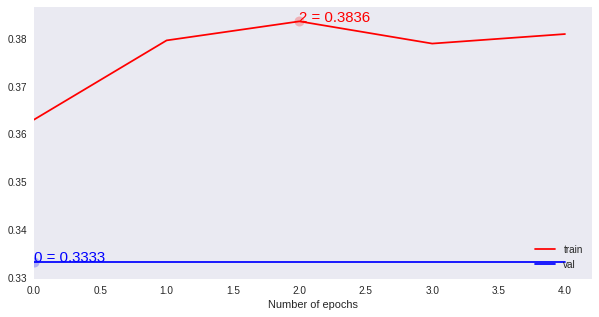

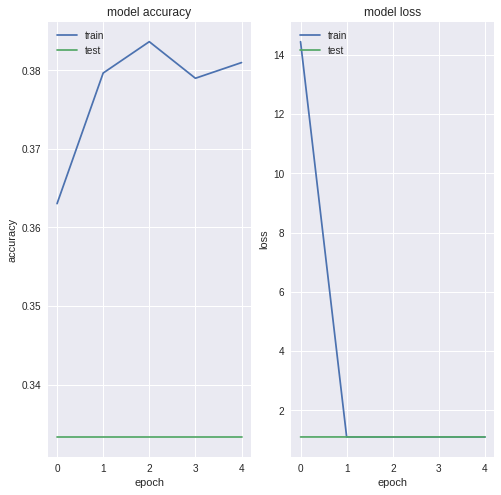

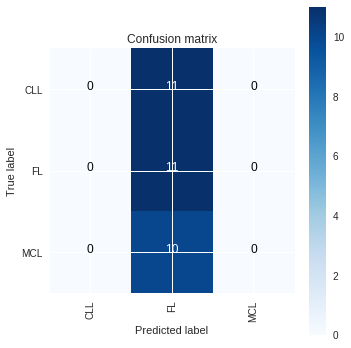

In [0]:
test_loss, test_accuracy = model.evaluate(image_label_test_ds, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 
#Y_true = np.argmax(test_labels) 
plot_model_learning_curve()
plt.show()  
plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

Epoch 1/5
59/59 [==============================] - 171s 3s/step - loss: 1.7697 - accuracy: 0.4529 - val_loss: 0.8833 - val_accuracy: 0.6533
Epoch 2/5
59/59 [==============================] - 162s 3s/step - loss: 0.7321 - accuracy: 0.7044 - val_loss: 1.0002 - val_accuracy: 0.5067
Epoch 3/5
59/59 [==============================] - 163s 3s/step - loss: 0.3380 - accuracy: 0.9327 - val_loss: 1.0110 - val_accuracy: 0.4267
Epoch 4/5
59/59 [==============================] - 163s 3s/step - loss: 0.1080 - accuracy: 0.9984 - val_loss: 0.9336 - val_accuracy: 0.6133
Epoch 5/5
59/59 [==============================] - 165s 3s/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.9824 - val_accuracy: 0.5867


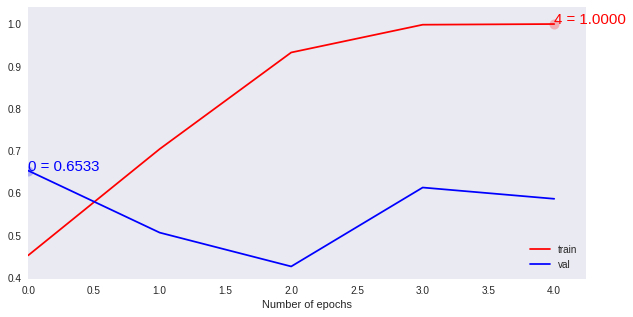

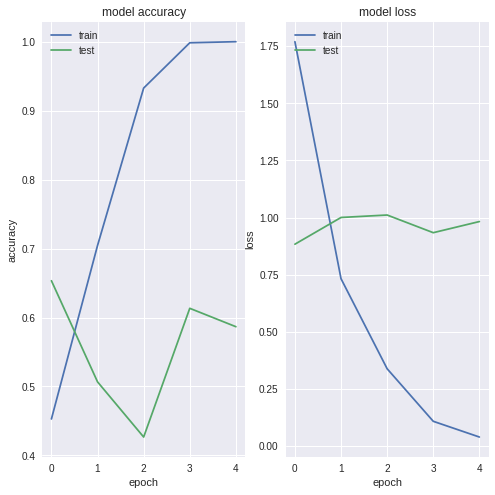

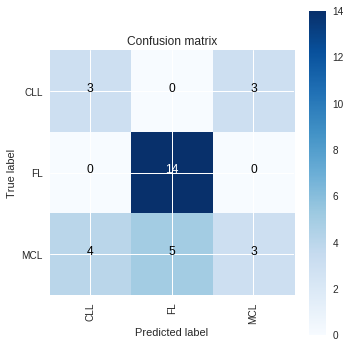

In [0]:

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_2 = model_2.fit(image_label_train_ds, epochs=5, steps_per_epoch=math.ceil(5*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_2.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_2)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()


Epoch 1/5
59/59 [==============================] - 225s 4s/step - loss: 1.4691 - accuracy: 0.3528 - val_loss: 1.0986 - val_accuracy: 0.3200
Epoch 2/5
59/59 [==============================] - 216s 4s/step - loss: 1.0938 - accuracy: 0.3565 - val_loss: 1.0593 - val_accuracy: 0.5333
Epoch 3/5
59/59 [==============================] - 217s 4s/step - loss: 1.0949 - accuracy: 0.3983 - val_loss: 1.0797 - val_accuracy: 0.4133
Epoch 4/5
59/59 [==============================] - 217s 4s/step - loss: 1.0598 - accuracy: 0.4338 - val_loss: 1.0090 - val_accuracy: 0.4400
Epoch 5/5
59/59 [==============================] - 216s 4s/step - loss: 0.9704 - accuracy: 0.5477 - val_loss: 0.9828 - val_accuracy: 0.5200


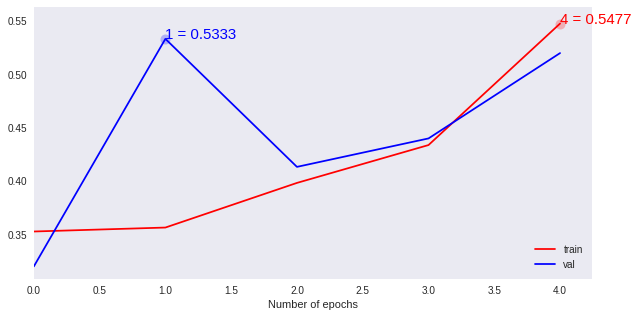

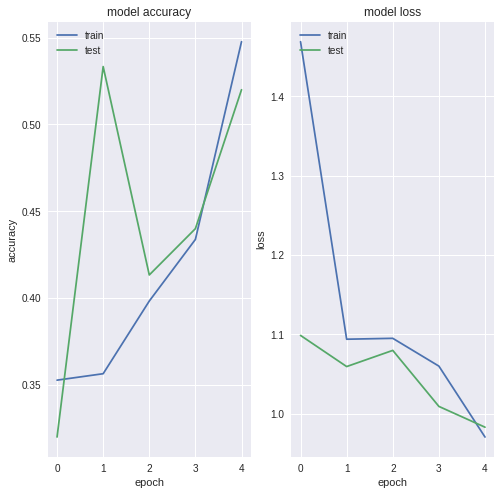

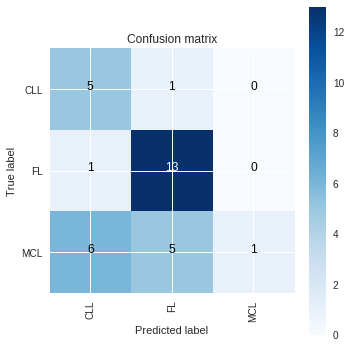

In [0]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_3 = model_3.fit(image_label_train_ds, epochs=5, steps_per_epoch=math.ceil(5*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_3.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_3)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

Epoch 1/5
59/59 [==============================] - 251s 4s/step - loss: 13.1804 - accuracy: 0.7818 - val_loss: 23.1046 - val_accuracy: 0.3333
Epoch 2/5
59/59 [==============================] - 250s 4s/step - loss: 0.0499 - accuracy: 0.9905 - val_loss: 32.4572 - val_accuracy: 0.2267
Epoch 3/5
59/59 [==============================] - 250s 4s/step - loss: 0.1133 - accuracy: 0.9831 - val_loss: 42.1106 - val_accuracy: 0.3867
Epoch 4/5
59/59 [==============================] - 249s 4s/step - loss: 0.1287 - accuracy: 0.9820 - val_loss: 44.8194 - val_accuracy: 0.5333
Epoch 5/5
59/59 [==============================] - 255s 4s/step - loss: 0.0136 - accuracy: 0.9984 - val_loss: 55.0598 - val_accuracy: 0.5467


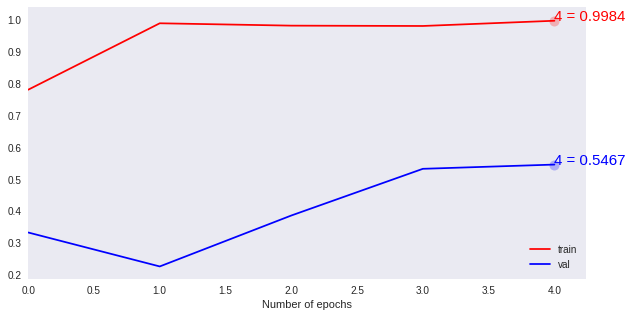

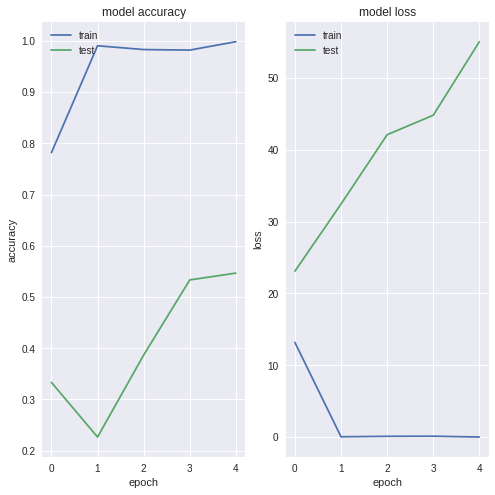

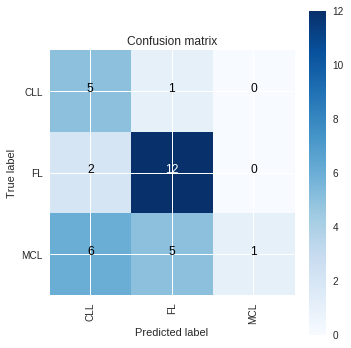

In [0]:

model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_4 = model_4.fit(image_label_train_ds, epochs=5, steps_per_epoch=math.ceil(5*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_4.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_4)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

In [0]:
def random_crop(img,label):
    tf_img = tf.image.random_crop(img,[40, 40, 3],1)
    
    return tf_img,label
  
image_label_train_random_crop = image_label_train_ds.map(random_crop)

#image_label_train_random_crop = image_label_train_random_crop.shuffle(buffer_size=5*image_count)
#image_label_train_random_crop = image_label_train_random_crop.repeat()
#image_label_train_random_crop = image_label_train_random_crop.batch(32)


def random_brightness(img,label):
    tf_img = tf.image.random_brightness(img,0.75,1)
    return tf_img,label
  
image_label_train_random_brightness = image_label_train_ds.map(random_brightness)
#image_label_train_random_brightness = image_label_train_random_brightness.shuffle(buffer_size=5*image_count)
#image_label_train_random_brightness = image_label_train_random_brightness.repeat()
#image_label_train_random_brightness = image_label_train_random_brightness.batch(32) 

def random_contrast(img,label):
    tf_img = tf.image.random_contrast(img,0.25,0.75,1)
    return tf_img,label
  

image_label_train_random_contrast = image_label_train_ds.map(random_contrast)

#image_label_train_random_contrast = image_label_train_random_contrast.shuffle(buffer_size=5*image_count)
#image_label_train_random_contrast = image_label_train_random_contrast.repeat()
#image_label_train_random_contrast = image_label_train_random_contrast.batch(32)


def random_flip_left_right(img,label):
    tf_img = tf.image.random_flip_left_right(img,1)
    return tf_img,label
  
image_label_train_random_flip_left_right = image_label_train_ds.map(random_flip_left_right)

#image_label_train_random_flip_left_right = image_label_train_random_flip_left_right.shuffle(buffer_size=5*image_count)
#image_label_train_random_flip_left_right = image_label_train_random_flip_left_right.repeat()
#image_label_train_random_flip_left_right = image_label_train_random_flip_left_right.batch(32)

def random_flip_up_down(img,label):
    tf_img = tf.image.random_flip_up_down(img,1)
    
    return tf_img,label
  
image_label_train_random_flip_up_down = image_label_train_ds.map(random_flip_up_down)

#image_label_train_random_flip_up_down = image_label_train_random_flip_up_down.shuffle(buffer_size=5*image_count)
#image_label_train_random_flip_up_down = image_label_train_random_flip_up_down.repeat()
#image_label_train_random_flip_up_down = image_label_train_random_flip_up_down.batch(32)


def random_saturation(img,label):
    tf_img = tf.image.random_saturation(img,0.3,0.8,1)
    return tf_img,label 
  
image_label_train_random_saturation = image_label_train_ds.map(random_saturation)

#image_label_train_random_saturation = image_label_train_random_saturation.shuffle(buffer_size=5*image_count)
#image_label_train_random_saturation = image_label_train_random_saturation.repeat()
#image_label_train_random_saturation = image_label_train_random_saturation.batch(32)

def rot90(img,label):
  tf_img =tf.image.rot90(img,1)
  return tf_img,label

image_label_train_rot90 = image_label_train_ds.map(rot90)#.shuffle(buffer_size=5*image_count)#.repeat().batch(32)

def concet(ds):
  ds0 = ds[0]
  for ds1 in ds[1:]:
     ds0 = ds0.concatenate(ds1)
  return ds0  

In [0]:
  

aug =[image_label_train_random_crop,image_label_train_random_brightness,image_label_train_random_contrast,image_label_train_random_flip_left_right,
      image_label_train_random_flip_up_down,image_label_train_random_saturation,image_label_train_rot90]

image_label_ds_aug = concet(aug)


image_label_ds_aug = image_label_ds_aug.shuffle(buffer_size=20*image_count)
image_label_ds_aug = image_label_ds_aug.repeat()
image_label_ds_aug = image_label_ds_aug.batch(32)
#image_label_ds_aug = image_label_ds_aug.prefetch(buffer_size=AUTOTUNE) 
image_label_ds_aug

<BatchDataset shapes: ((None, 40, 40, 3), (None,)), types: (tf.float32, tf.int64)>

Epoch 1/8
313/313 [==============================] - 1360s 4s/step - loss: 5.1509 - accuracy: 0.5534 - val_loss: 184.9271 - val_accuracy: 0.3733
Epoch 2/8
313/313 [==============================] - 1348s 4s/step - loss: 0.5700 - accuracy: 0.7310 - val_loss: 1.3695 - val_accuracy: 0.4800
Epoch 3/8
313/313 [==============================] - 1331s 4s/step - loss: 0.2694 - accuracy: 0.8950 - val_loss: 2.4242 - val_accuracy: 0.4400
Epoch 4/8
313/313 [==============================] - 1360s 4s/step - loss: 0.1270 - accuracy: 0.9580 - val_loss: 4.4489 - val_accuracy: 0.3200
Epoch 5/8
313/313 [==============================] - 1355s 4s/step - loss: 0.0943 - accuracy: 0.9643 - val_loss: 3.7837 - val_accuracy: 0.3467
Epoch 6/8
313/313 [==============================] - 1368s 4s/step - loss: 0.0591 - accuracy: 0.9827 - val_loss: 4.8415 - val_accuracy: 0.4400
Epoch 7/8
313/313 [==============================] - 1345s 4s/step - loss: 0.1081 - accuracy: 0.9709 - val_loss: 1.3634 - val_accuracy: 0.38

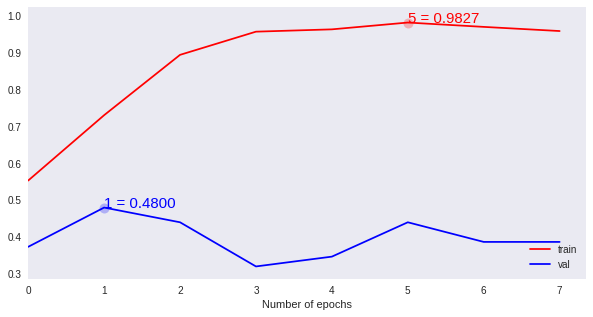

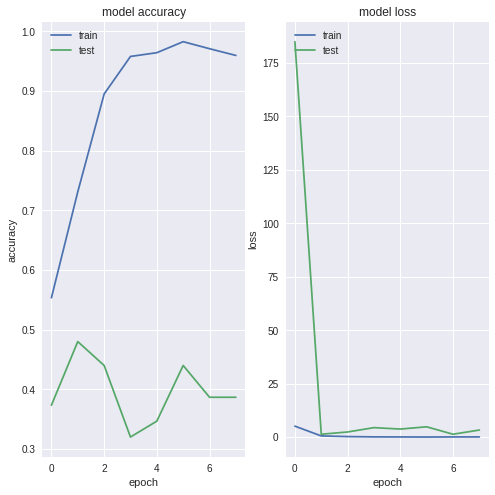

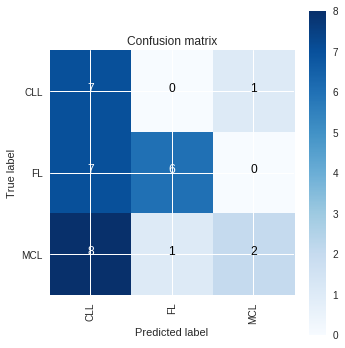

In [0]:

model_5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_5.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_5 = model_5.fit(image_label_ds_aug, epochs=8, steps_per_epoch=math.ceil(10000/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_5.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_5)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

Epoch 1/8
293/293 [==============================] - 1219s 4s/step - loss: 4.2649 - accuracy: 0.6134 - val_loss: 9.5045 - val_accuracy: 0.2500
Epoch 2/8
293/293 [==============================] - 1214s 4s/step - loss: 0.2668 - accuracy: 0.9209 - val_loss: 1.1763 - val_accuracy: 0.5645
Epoch 3/8
293/293 [==============================] - 1179s 4s/step - loss: 0.0855 - accuracy: 0.9774 - val_loss: 1.5373 - val_accuracy: 0.5000
Epoch 4/8
293/293 [==============================] - 1172s 4s/step - loss: 0.0395 - accuracy: 0.9910 - val_loss: 2.0487 - val_accuracy: 0.4919
Epoch 5/8
293/293 [==============================] - 1165s 4s/step - loss: 0.0756 - accuracy: 0.9778 - val_loss: 18.1455 - val_accuracy: 0.4839
Epoch 6/8
293/293 [==============================] - 1164s 4s/step - loss: 0.3154 - accuracy: 0.9407 - val_loss: 2.2910 - val_accuracy: 0.5081
Epoch 7/8
293/293 [==============================] - 1180s 4s/step - loss: 0.0536 - accuracy: 0.9860 - val_loss: 5.4557 - val_accuracy: 0.403

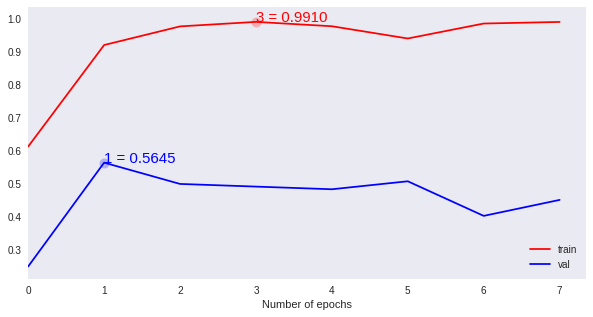

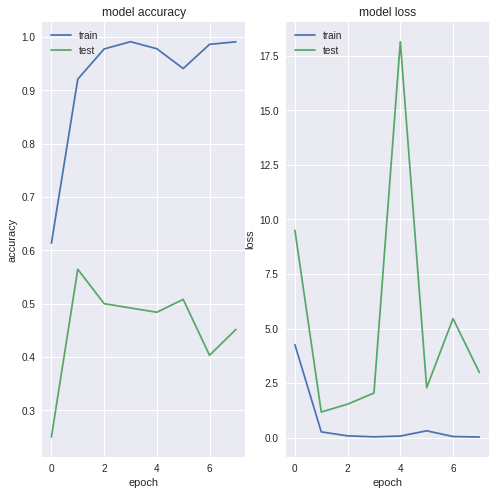

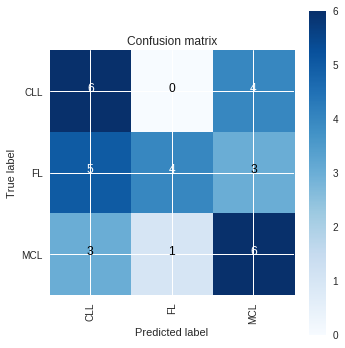

In [0]:

model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_6.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_6 = model_6.fit(image_label_ds_aug, epochs=8, steps_per_epoch=math.ceil(25*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_6.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_6)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

Epoch 1/5
293/293 [==============================] - 1202s 4s/step - loss: 4.2093 - accuracy: 0.3513 - val_loss: 1.0897 - val_accuracy: 0.4758
Epoch 2/5
293/293 [==============================] - 1193s 4s/step - loss: 1.0963 - accuracy: 0.3692 - val_loss: 1.1554 - val_accuracy: 0.4677
Epoch 3/5
293/293 [==============================] - 1194s 4s/step - loss: 1.0961 - accuracy: 0.3692 - val_loss: 4.5740 - val_accuracy: 0.4677
Epoch 4/5
293/293 [==============================] - 1148s 4s/step - loss: 1.0963 - accuracy: 0.3658 - val_loss: 5.8309 - val_accuracy: 0.4597
Epoch 5/5
293/293 [==============================] - 1156s 4s/step - loss: 1.0932 - accuracy: 0.3719 - val_loss: 5.0140 - val_accuracy: 0.4274


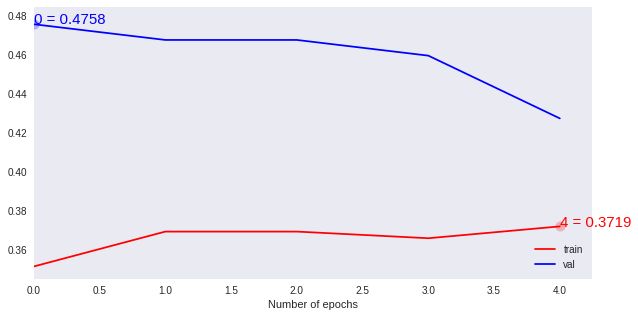

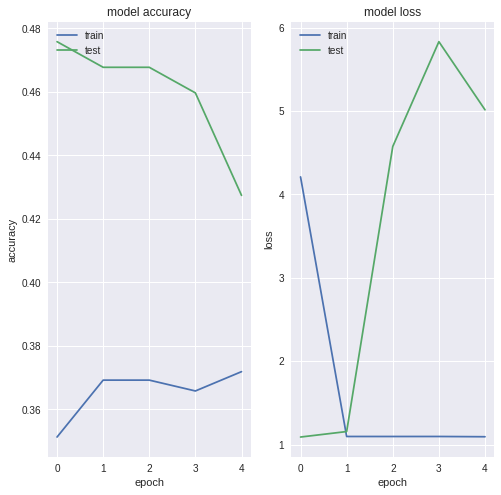

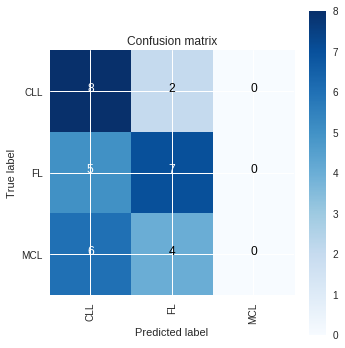

In [0]:

model_7 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_7.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_7 = model_7.fit(image_label_ds_aug, epochs=5, steps_per_epoch=math.ceil(25*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_7.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_7)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

In [0]:

model_8 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_8.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_8 = model_8.fit(image_label_train_ds, epochs=5, steps_per_epoch=math.ceil(20*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_8.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_8)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

W0413 18:57:06.603935 139853403572096 training_utils.py:1314] Expected a shuffled dataset but input dataset `x` is not shuffled. Please invoke `shuffle()` on input dataset.


Epoch 1/5


ValueError: ignored

Epoch 1/5
257/257 [==============================] - 1079s 4s/step - loss: 8.3802 - accuracy: 0.3559 - val_loss: 243.8520 - val_accuracy: 0.3629
Epoch 2/5
257/257 [==============================] - 999s 4s/step - loss: 1.0987 - accuracy: 0.3273 - val_loss: 217.6216 - val_accuracy: 0.3548
Epoch 3/5
257/257 [==============================] - 991s 4s/step - loss: 1.0988 - accuracy: 0.3281 - val_loss: 203.6522 - val_accuracy: 0.3629
Epoch 4/5
257/257 [==============================] - 1036s 4s/step - loss: 1.0986 - accuracy: 0.3241 - val_loss: 198.6107 - val_accuracy: 0.3629
Epoch 5/5
257/257 [==============================] - 1062s 4s/step - loss: 1.0987 - accuracy: 0.3283 - val_loss: 193.3844 - val_accuracy: 0.3629


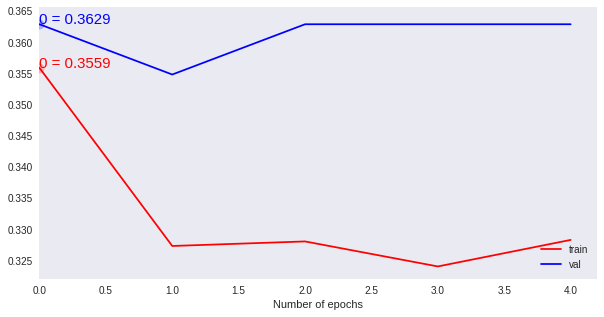

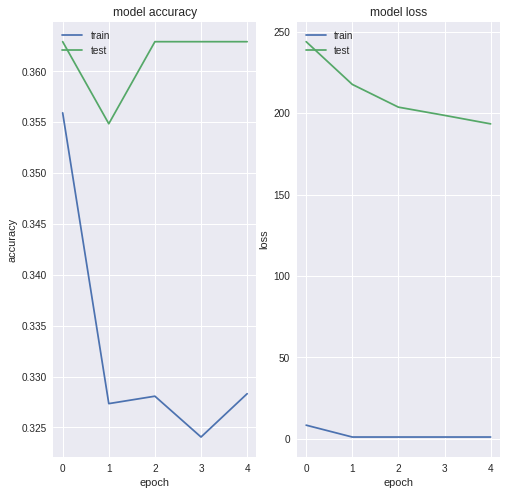

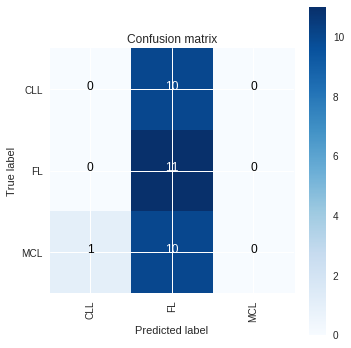

In [0]:

model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(225, 225, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),+
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_9.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_9 = model_9.fit(image_label_ds_aug, epochs=5, steps_per_epoch=math.ceil(20*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs')])
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_9.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_9)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

In [0]:
import random
aug_f =[random_crop,random_brightness,random_contrast,random_flip_left_right,random_flip_up_down,random_saturation,rot90]


def random_aug(img,label):
  rand = random.randint(0, 1);
  if rand == 1 :
    rand_f = random.randint(0, 6);
    f = aug_f[f]
    return f(img,label)
  return img,label

image_label_ds_aug_1 = image_label_train_ds.map(random_aug)

image_label_ds_aug_1 = image_label_ds_aug_1.shuffle(buffer_size=10*image_count)
image_label_ds_aug_1 = image_label_ds_aug_1.repeat()
image_label_ds_aug_1 = image_label_ds_aug_1.batch(32)
image_label_ds_aug_1

<BatchDataset shapes: ((None, 40, 40, 3), (None,)), types: (tf.float32, tf.int64)>

Epoch 1/5
257/257 [==============================] - 66s 256ms/step - loss: 0.2777 - accuracy: 0.9289 - val_loss: 5.4502 - val_accuracy: 0.3468
Epoch 2/5
257/257 [==============================] - 62s 240ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.9664 - val_accuracy: 0.5403
Epoch 3/5
257/257 [==============================] - 61s 237ms/step - loss: 7.2211e-04 - accuracy: 1.0000 - val_loss: 0.9575 - val_accuracy: 0.6694
Epoch 4/5
257/257 [==============================] - 61s 236ms/step - loss: 2.7556e-04 - accuracy: 1.0000 - val_loss: 1.1089 - val_accuracy: 0.6774
Epoch 5/5
257/257 [==============================] - 60s 234ms/step - loss: 2.0238e-04 - accuracy: 1.0000 - val_loss: 1.1557 - val_accuracy: 0.6855


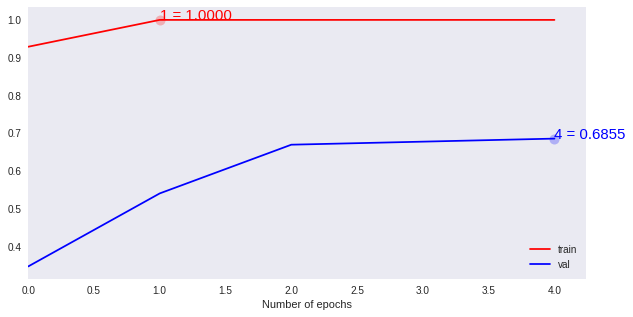

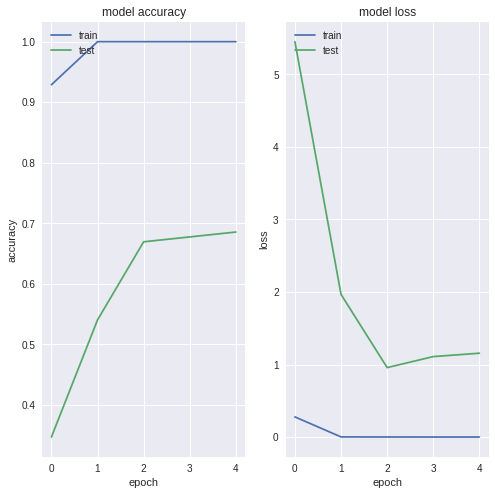

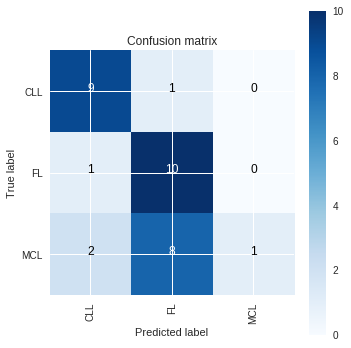

In [0]:

model_1_0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_1_0.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_1_0 = model_1_0.fit(image_label_ds_aug_1, epochs=5, steps_per_epoch=math.ceil(20*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs'),
tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss')])
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_1_0.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_1_0)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

Epoch 1/10
129/129 [==============================] - 27s 209ms/step - loss: 0.4586 - accuracy: 0.8580 - val_loss: 1.0075 - val_accuracy: 0.4274
Epoch 2/10
129/129 [==============================] - 24s 185ms/step - loss: 0.0138 - accuracy: 0.9981 - val_loss: 1.1048 - val_accuracy: 0.4355
Epoch 3/10
129/129 [==============================] - 24s 185ms/step - loss: 0.0060 - accuracy: 0.9993 - val_loss: 1.6742 - val_accuracy: 0.4597


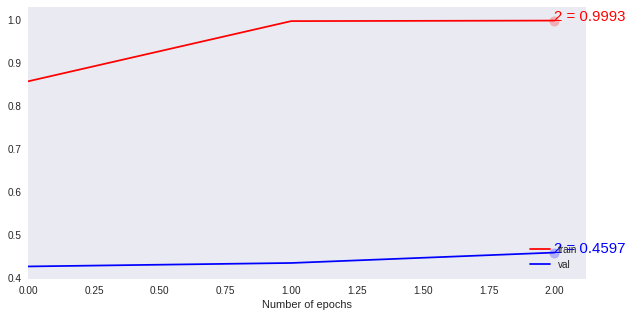

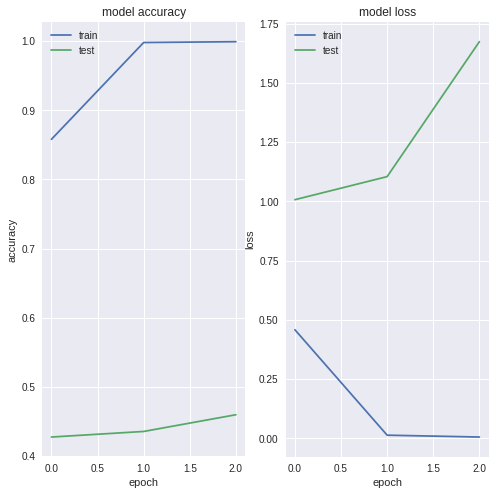

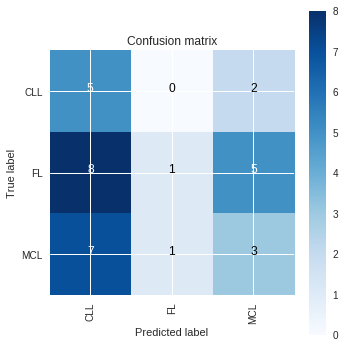

In [0]:

model_1_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(40, 40, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_1_1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_1_1 = model_1_1.fit(image_label_ds_aug_1, epochs=10, steps_per_epoch=math.ceil(10*image_count/BATCH_SIZE),validation_data=(image_label_test_ds),callbacks = [MetricsCheckpoint('logs'),
tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss')])
for test_images, test_labels in image_label_test_ds.take(2):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_1_1.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 

plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_1_1)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

Epoch 1/25
164/164 [==============================] - 27s 166ms/step - loss: 0.9630 - accuracy: 0.6357 - val_loss: 4.3252 - val_accuracy: 0.3333
Epoch 2/25
164/164 [==============================] - 21s 129ms/step - loss: 0.4306 - accuracy: 0.8215 - val_loss: 2.1996 - val_accuracy: 0.4311
Epoch 3/25
164/164 [==============================] - 21s 129ms/step - loss: 0.2595 - accuracy: 0.9026 - val_loss: 1.1593 - val_accuracy: 0.6489
Epoch 4/25
164/164 [==============================] - 21s 129ms/step - loss: 0.1910 - accuracy: 0.9289 - val_loss: 1.5428 - val_accuracy: 0.6800
Epoch 5/25
164/164 [==============================] - 23s 141ms/step - loss: 0.1460 - accuracy: 0.9478 - val_loss: 0.8167 - val_accuracy: 0.7556
Epoch 6/25
164/164 [==============================] - 23s 142ms/step - loss: 0.1209 - accuracy: 0.9579 - val_loss: 2.7688 - val_accuracy: 0.6667
Epoch 7/25
164/164 [==============================] - 22s 135ms/step - loss: 0.0781 - accuracy: 0.9722 - val_loss: 0.8639 - val_ac

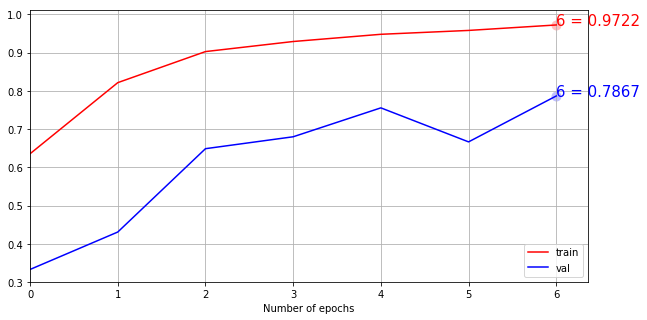

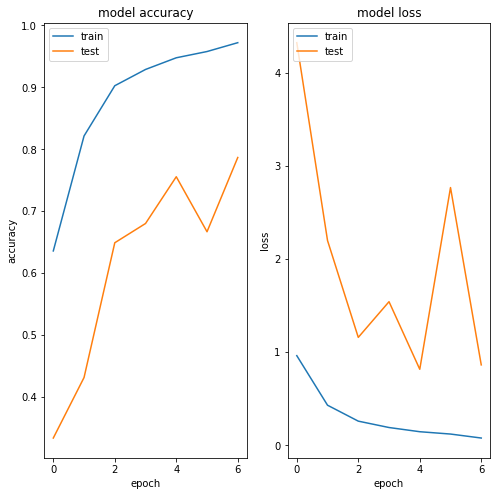

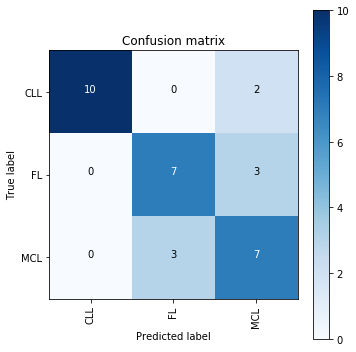

In [0]:

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
img_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
img_label_ds = tf.data.Dataset.zip((img_ds, label_ds))
img_label_ds.shuffle(buffer_size=5*image_count, reshuffle_each_iteration = False )

train_size = int(0.7 * image_count)
val_size = int(0.15 * image_count)
test_size = int(0.15 * image_count)

train_dataset = img_label_ds.take(train_size)
test_dataset = img_label_ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)
train_dataset = train_dataset.shuffle(buffer_size=5*train_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)

#test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(BATCH_SIZE)

#val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(BATCH_SIZE)

model_1_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(36, 36, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(254, activation=tf.nn.relu),
    tf.keras.layers.Dense(3,activation=tf.nn.softmax)
])

model_1_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_1_2 = model_1_2.fit(train_dataset, epochs=25, steps_per_epoch=math.ceil(5*train_size/BATCH_SIZE),validation_data=(val_dataset) ,callbacks = [MetricsCheckpoint('logs'),
tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss')])
for test_images, test_labels in test_dataset.take(15):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()

y_pred = model_1_2.predict(test_images)
Y_pred_classes = np.argmax(y_pred,axis=1) 
print("acutal: ",test_labels[0],"predict: ", y_pred[0])
plot_model_learning_curve()
plt.show()  
plot_learning_curve(history_1_2)
plt.show()
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels =label_names) 
plt.show()

In [0]:
cll_path_ds = tf.data.Dataset.from_tensor_slices(cll_only)
img_cll_ds = cll_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#label_cll_ds = tf.data.Dataset.from_tensor_slices(tf.cast(cll_label, tf.int64))
cll=[]
img_cll_ds = img_cll_ds.batch(BATCH_SIZE)
for test_images in img_cll_ds.take(10):
  cll.append(test_images.numpy())
c=0
r=0
for b in cll:
  y_pred = model_1_2.predict(test_images)
  Y_pred_classes = np.argmax(y_pred,axis=1)
  for i in range(32):
    c+=1
    print(c,": ",y_pred[i]," => ",Y_pred_classes[i])
    if Y_pred_classes[i] == 0:
      r+=1

print("acc", r/320)      

1 :  [9.99930024e-01 1.25455135e-05 5.74783408e-05]  =>  0
2 :  [9.999523e-01 2.997111e-07 4.738161e-05]  =>  0
3 :  [0.12491279 0.03038329 0.84470385]  =>  2
4 :  [9.999492e-01 1.805546e-11 5.076347e-05]  =>  0
5 :  [9.9986446e-01 3.7911260e-10 1.3555335e-04]  =>  0
6 :  [9.9993193e-01 6.2157080e-05 5.9679933e-06]  =>  0
7 :  [9.9999833e-01 2.9877341e-07 1.2652462e-06]  =>  0
8 :  [9.9966919e-01 3.6414523e-05 2.9434409e-04]  =>  0
9 :  [9.9999475e-01 7.1509226e-12 5.2148957e-06]  =>  0
10 :  [0.03593303 0.0256951  0.93837184]  =>  2
11 :  [0.8836094  0.00233179 0.11405876]  =>  0
12 :  [9.9835157e-01 3.1705188e-06 1.6452178e-03]  =>  0
13 :  [9.9999285e-01 2.7385706e-06 4.3629507e-06]  =>  0
14 :  [9.9951875e-01 1.0534955e-04 3.7593840e-04]  =>  0
15 :  [9.9993825e-01 4.2369405e-07 6.1276914e-05]  =>  0
16 :  [1.7366287e-01 1.9439581e-06 8.2633519e-01]  =>  2
17 :  [9.9935824e-01 1.1999457e-08 6.4178969e-04]  =>  0
18 :  [9.9999905e-01 3.2581087e-07 6.3908800e-07]  =>  0
19 :  [9.9999

In [0]:
fl_path_ds = tf.data.Dataset.from_tensor_slices(fl_only)
img_fl_ds = fl_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#label_cll_ds = tf.data.Dataset.from_tensor_slices(tf.cast(cll_label, tf.int64))
fl=[]
img_fl_ds = img_fl_ds.batch(BATCH_SIZE)
for test_images in img_fl_ds.take(10):
  fl.append(test_images.numpy())
c=0
r=0
for b in cll:
  y_pred = model_1_2.predict(test_images)
  Y_pred_classes = np.argmax(y_pred,axis=1)
  for i in range(32):
    c+=1
    print(c,": ",y_pred[i]," => ",Y_pred_classes[i])
    if Y_pred_classes[i] == 1:
      r+=1

print("acc", r/320)  

1 :  [8.0986560e-09 9.9950922e-01 4.9078604e-04]  =>  1
2 :  [7.4045315e-06 9.9879813e-01 1.1944259e-03]  =>  1
3 :  [0.01432382 0.181558   0.8041182 ]  =>  2
4 :  [1.0074607e-07 9.9913615e-01 8.6379744e-04]  =>  1
5 :  [5.8586156e-05 9.9857068e-01 1.3706940e-03]  =>  1
6 :  [7.3966410e-05 9.9989939e-01 2.6572125e-05]  =>  1
7 :  [6.9394341e-06 9.9872464e-01 1.2684946e-03]  =>  1
8 :  [1.4927034e-06 4.6240380e-01 5.3759474e-01]  =>  2
9 :  [1.470804e-04 9.984023e-01 1.450628e-03]  =>  1
10 :  [8.0321415e-04 9.9690396e-01 2.2927346e-03]  =>  1
11 :  [0.08926962 0.87857264 0.03215774]  =>  1
12 :  [2.3594450e-03 9.9718297e-01 4.5771085e-04]  =>  1
13 :  [0.54860437 0.4436202  0.00777542]  =>  0
14 :  [4.5137895e-05 9.0370256e-01 9.6252322e-02]  =>  1
15 :  [8.0582366e-05 9.9856263e-01 1.3568397e-03]  =>  1
16 :  [8.5843039e-06 7.5804323e-01 2.4194819e-01]  =>  1
17 :  [0.00140218 0.99735594 0.00124181]  =>  1
18 :  [3.8198032e-04 7.4258399e-01 2.5703409e-01]  =>  1
19 :  [0.7165329  0.21

In [0]:
s=0
for i in range(len(test_labels)):
  print("acutal: ",test_labels[i],"predict: ", y_pred[i])
  if np.argmax(y_pred[i]) == test_labels[i]:
    s+=1
print("acc : ",s/len(test_labels))    

acutal:  1 predict:  [0.00786018 0.14745733 0.8446825 ]
acutal:  0 predict:  [9.947320e-01 7.935851e-06 5.260062e-03]
acutal:  0 predict:  [0.04792298 0.9393492  0.01272793]
acutal:  2 predict:  [0.05976541 0.9286056  0.01162898]
acutal:  0 predict:  [0.03892218 0.00413414 0.95694363]
acutal:  2 predict:  [6.5305753e-04 2.4979582e-04 9.9909711e-01]
acutal:  2 predict:  [4.7238659e-02 4.7241514e-07 9.5276088e-01]
acutal:  1 predict:  [5.444561e-06 9.999876e-01 6.886732e-06]
acutal:  0 predict:  [9.99887109e-01 1.12913825e-04 4.31656879e-08]
acutal:  1 predict:  [7.0540591e-07 9.9977988e-01 2.1940883e-04]
acutal:  0 predict:  [8.76759052e-01 1.23240285e-01 6.75912077e-07]
acutal:  2 predict:  [9.8036247e-01 1.1267050e-06 1.9636309e-02]
acutal:  0 predict:  [3.2813904e-01 2.5800520e-05 6.7183518e-01]
acutal:  0 predict:  [9.9980980e-01 1.7587717e-04 1.4342572e-05]
acutal:  0 predict:  [9.9999952e-01 2.1410800e-07 1.8600198e-07]
acutal:  2 predict:  [0.9798646  0.00317667 0.01695876]
acuta

In [0]:
tfjs.converters.save_keras_model(model_1_2, 'lymphoma_model_1_5js')
!zip -r model_1_5js.zip 'lymphoma_model_1_5js'

  adding: lymphoma_model_1_5js/ (stored 0%)
  adding: lymphoma_model_1_5js/model.json (deflated 85%)
  adding: lymphoma_model_1_5js/group1-shard1of1.bin (deflated 7%)


In [0]:
#model_9.save('lymphoma_9.h5')
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model_1_5js.zip'})
uploaded.SetContentFile('model_1_5js.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

    100% |████████████████████████████████| 993kB 21.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


W0417 19:49:03.036395 139706497386368 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Uploaded file with ID 143N39CVN1oOFcMDg0gBFrgvzVcGaCly4


In [0]:
import inspect
inspect.getmembers(tf.lite.TFLiteConverter, predicate=inspect.ismethod)


[('from_concrete_functions',
  <bound method TFLiteConverterV2.from_concrete_functions of <class 'tensorflow.lite.python.lite.TFLiteConverterV2'>>),
 ('from_keras_model',
  <bound method TFLiteConverterV2.from_keras_model of <class 'tensorflow.lite.python.lite.TFLiteConverterV2'>>),
 ('from_saved_model',
  <bound method TFLiteConverterV2.from_saved_model of <class 'tensorflow.lite.python.lite.TFLiteConverterV2'>>)]

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_8)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'converted_model.tflite'})
uploaded.SetContentFile('converted_model.tflite')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

W0412 21:56:50.512007 140600991090560 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Uploaded file with ID 1uNAmQPatLXpDwbf4v1dfIrGtbVh9A3Fn


In [0]:
 tfjs.converters.save_keras_model(model_1_2, 'lymphoma_model_1_2js')
  

In [0]:
!zip -r model_1_2js.zip 'lymphoma_model_1_2js'


  adding: lymphoma_model_1_2js/ (stored 0%)
  adding: lymphoma_model_1_2js/group1-shard2of2.bin (deflated 8%)
  adding: lymphoma_model_1_2js/model.json (deflated 82%)
  adding: lymphoma_model_1_2js/group1-shard1of2.bin (deflated 8%)


In [0]:
!ls -d */
!zip -r lymphoma_modeljs.zip lymphoma_modeljs


lymphoma/  model/  sample_data/
  adding: model/ (stored 0%)
  adding: model/group1-shard11of25.bin (deflated 7%)
  adding: model/group1-shard22of25.bin (deflated 7%)
  adding: model/model.json (deflated 80%)
  adding: model/group1-shard12of25.bin (deflated 7%)
  adding: model/group1-shard5of25.bin (deflated 7%)
  adding: model/group1-shard15of25.bin (deflated 7%)
  adding: model/group1-shard23of25.bin (deflated 7%)
  adding: model/group1-shard2of25.bin (deflated 7%)
  adding: model/group1-shard24of25.bin (deflated 7%)
  adding: model/group1-shard10of25.bin (deflated 7%)
  adding: model/group1-shard9of25.bin (deflated 7%)
  adding: model/group1-shard1of25.bin (deflated 7%)
  adding: model/group1-shard20of25.bin (deflated 7%)
  adding: model/group1-shard13of25.bin (deflated 7%)
  adding: model/group1-shard6of25.bin (deflated 7%)
  adding: model/group1-shard21of25.bin (deflated 7%)
  adding: model/group1-shard18of25.bin (deflated 7%)
  adding: model/group1-shard7of25.bin (deflated 7%)
  

In [0]:
# Create & upload a file.

uploaded = drive.CreateFile({'title': 'model_1_2js.zip'})
uploaded.SetContentFile('model.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 170TuZdu8eDDwueY69WxnTC54lB2zvQo0


In [0]:
model_loaded = tf.keras.models.load_model('lymphoma.h5')
model_loaded.summary()

OSError: ignored

In [0]:
 tf.saved_model.save(
    model_1_0,
    'tensflow_model_1_0',
    signatures=None
)

In [0]:
!zip -r tensorflow_model_1_0.zip 'tensflow_model_1_0'

  adding: tensflow_model_1_0/ (stored 0%)
  adding: tensflow_model_1_0/assets/ (stored 0%)
  adding: tensflow_model_1_0/variables/ (stored 0%)
  adding: tensflow_model_1_0/variables/variables.index (deflated 68%)
  adding: tensflow_model_1_0/variables/variables.data-00000-of-00002 (deflated 10%)
  adding: tensflow_model_1_0/variables/variables.data-00001-of-00002 (deflated 89%)
  adding: tensflow_model_1_0/saved_model.pb (deflated 88%)


In [0]:
from google.colab import files
files.download('tensflow_model') 

MessageError: ignored

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model_1_2js.zip'})
uploaded.SetContentFile('model_1_2js.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

    100% |████████████████████████████████| 993kB 20.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


W0416 14:59:42.473980 139825362864000 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Uploaded file with ID 1KHwo1x2rhVAURRHZ0EbBHpK4Mnn5MUi8


In [0]:
converter=tf.lite.TFLiteConverter.from_saved_model('tensflow_model')
converter.post_training_quantize=True
tflite_quantized_model=converter.convert()
open('quantized_model.tflite', 'wb').write(tflite_quantized_model)

102844940

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
uploaded = drive.CreateFile({'title': 'quantized_model.tflite'})
uploaded.SetContentFile('quantized_model.tflite')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

W0413 23:23:53.760011 139853403572096 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

Uploaded file with ID 1RHRiqdRteoEdmz8ruDWSZNvhSD3AJW8v
